In [1]:
from __future__ import print_function

import torch.utils.data
import torchvision.datasets as datasets

from StyleCNN2 import *
from utils import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [2]:
def show_img(img_path):
    img=mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()

In [3]:
import torch.optim as optim
import torchvision.models as models

from modules.GramMatrix import *
from modules.ScaledTanh import *

class StyleCNN(object):
    def __init__(self, style):
        super(StyleCNN, self).__init__()

        self.style = style
        self.content_layers = ['conv_4']
        self.style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
        self.content_weight = 1
        self.style_weight = 1000

        self.use_cuda = torch.cuda.is_available()

        self.transform_network = nn.Sequential(nn.ReflectionPad2d(40),
                              nn.Conv2d(3, 32, 9, stride=1, padding=4),
                              nn.InstanceNorm2d(32, affine=True),
                              nn.ReLU(),

                              nn.Conv2d(32, 64, 3, stride=2, padding=1),
                              nn.InstanceNorm2d(64, affine=True),
                              nn.ReLU(),

                              nn.Conv2d(64, 128, 3, stride=2, padding=1),
                              nn.InstanceNorm2d(128, affine=True),
                              nn.ReLU(),

                              nn.Conv2d(128, 128, 3, stride=1,padding=0),
                              nn.InstanceNorm2d(128, affine=True),
                              nn.ReLU(),
                              nn.Conv2d(128, 128, 3, stride=1, padding=0),
                              nn.InstanceNorm2d(128, affine=True),
                              nn.ReLU(),

                              nn.Conv2d(128, 128, 3, stride=1, padding=0),
                              nn.InstanceNorm2d(128, affine=True),
                              nn.ReLU(),
                              nn.Conv2d(128, 128, 3, stride=1, padding=0),
                              nn.InstanceNorm2d(128, affine=True),
                              nn.ReLU(),

                              nn.Conv2d(128, 128, 3, stride=1, padding=0),
                              nn.InstanceNorm2d(128, affine=True),
                              nn.ReLU(),
                              nn.Conv2d(128, 128, 3, stride=1, padding=0),
                              nn.InstanceNorm2d(128, affine=True),
                              nn.ReLU(),

                              nn.Conv2d(128, 128, 3, stride=1, padding=0),
                              nn.InstanceNorm2d(128, affine=True),
                              nn.ReLU(),
                              nn.Conv2d(128, 128, 3, stride=1, padding=0),
                              nn.InstanceNorm2d(128, affine=True),
                              nn.ReLU(),

                              nn.Conv2d(128, 128, 3, stride=1, padding=0),
                              nn.InstanceNorm2d(128, affine=True),
                              nn.ReLU(),
                              nn.Conv2d(128, 128, 3, stride=1, padding=0),
                              nn.InstanceNorm2d(128, affine=True),
                              nn.ReLU(),

                              nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
                              nn.InstanceNorm2d(64, affine=True),
                              nn.ReLU(),

                              nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
                              nn.InstanceNorm2d(32, affine=True),
                              nn.ReLU(),

                              nn.Conv2d(32, 3, 9, stride=1, padding=4),
                              nn.InstanceNorm2d(3, affine=True),
                              nn.ReLU()
                                )

        try:
            self.transform_network.load_state_dict(torch.load("models/model"))
        except IOError:
            pass

        self.loss_network = models.vgg19(pretrained=True)

        self.loss_layers = []
        index = 0
        i = 1
        for layer in list(self.loss_network.features):
            losses = ""
            if isinstance(layer, nn.Conv2d):
                name = "conv_" + str(i)

                if name in self.content_layers:
                    losses += "c"
                if name in self.style_layers:
                    losses += "s"

                if losses != "":
                    self.loss_layers.append((index, losses))

            if isinstance(layer, nn.ReLU):
                i += 1

            index += 1

        self.gram = GramMatrix()
        self.loss = nn.MSELoss()
#         self.optimizer = optim.Adam(self.transform_network.parameters(), lr=1e-3)

        if self.use_cuda:
            self.transform_network.cuda()
            self.loss_network.cuda()
            self.gram.cuda()

    def train(self, input):
        self.optimizer.zero_grad()

        content = input.clone()
        style = self.style.clone().expand_as(input)
        pastiche = self.transform_network(input)
        pastiche.data.clamp_(0, 255)
        pastiche_saved = pastiche.clone()
        
        content_loss = 0
        style_loss = 0

        start_layer = 0
        not_inplace = lambda item: nn.ReLU(inplace=False) if isinstance(item, nn.ReLU) else item
        for layer, losses in self.loss_layers:
            layers = list(self.loss_network.features.children())[start_layer:layer+1]
            layers = [not_inplace(item) for item in layers]

            features = nn.Sequential(*layers)
            if self.use_cuda:
                features.cuda()

            pastiche, content, style = features(pastiche), features(content), features(style)

            if "c" in losses:
                content_loss += self.loss(pastiche * self.content_weight, content.detach() * self.content_weight)
            if "s" in losses:
                pastiche_g, style_g = self.gram.forward(pastiche), self.gram.forward(style)
                style_loss += self.loss(pastiche_g * self.style_weight, style_g.detach() * self.style_weight)

            start_layer = layer + 1

        total_loss = content_loss + style_loss
        total_loss.backward()

        self.optimizer.step()

        return content_loss, style_loss, pastiche_saved

    def eval(self, input):
        return self.transform_network.forward(input)

    def save(self):
        torch.save(self.transform_network.state_dict(), "models/model")


In [11]:
import torch.utils.data
import torchvision.datasets as datasets

# from StyleCNN import *
from utils import *

# CUDA Configurations
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
# Content and style
style = image_loader("styles/starry_night.jpeg").type(dtype)
content = None
num_epochs = 3000
N = 4
style_cnn = StyleCNN(style)

In [12]:
from torchsummary import summary
summary(style_cnn.transform_network, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 336, 336]               0
            Conv2d-2         [-1, 32, 336, 336]           7,808
    InstanceNorm2d-3         [-1, 32, 336, 336]              64
              ReLU-4         [-1, 32, 336, 336]               0
            Conv2d-5         [-1, 64, 168, 168]          18,496
    InstanceNorm2d-6         [-1, 64, 168, 168]             128
              ReLU-7         [-1, 64, 168, 168]               0
            Conv2d-8          [-1, 128, 84, 84]          73,856
    InstanceNorm2d-9          [-1, 128, 84, 84]             256
             ReLU-10          [-1, 128, 84, 84]               0
           Conv2d-11          [-1, 128, 82, 82]         147,584
   InstanceNorm2d-12          [-1, 128, 82, 82]             256
             ReLU-13          [-1, 128, 82, 82]               0
           Conv2d-14          [-1, 128,

In [13]:
def main():
    # Contents
    style_cnn.optimizer = optim.Adam(style_cnn.transform_network.parameters(), lr=1e-4)
    coco = datasets.ImageFolder(root='contents/', transform=loader)
    train_loader = torch.utils.data.DataLoader(coco, batch_size=N, shuffle=False, **kwargs)

    if content is not None:
        style_cnn.eval(content)
        return

    iter = 0
    for i in range(num_epochs):
        num_batches = 0
        for x_batch, _ in train_loader:
            input_content = Variable(x_batch).type(dtype)
            content_loss, style_loss, pastiche = style_cnn.train(input_content)
            if iter % 10 == 0:
                print("Iteration: %d" % (iter))
                print("Content loss: %f" % (content_loss.data[0]))
                print("Style loss: %f" % (style_loss.data[0]))
                
            if iter % 100 == 0:
                path = "outputs/%d_" % (iter)
                paths = [path + str(n) + ".png" for n in range(N)]
                save_images(pastiche, paths)
                style_cnn.save()

            iter += 1
            num_batches += 1

            if num_batches == 2:
                break

In [19]:
main()

Iteration: 0


/home/ky2371/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Content loss: 2.483064
Style loss: 0.774806


/home/ky2371/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 10
Content loss: 3.101103
Style loss: 1.427525
Iteration: 20
Content loss: 2.816714
Style loss: 0.999316
Iteration: 30
Content loss: 2.646838
Style loss: 0.847899
Iteration: 40
Content loss: 2.539523
Style loss: 0.799145
Iteration: 50
Content loss: 2.481803
Style loss: 0.772637
Iteration: 60
Content loss: 2.439689
Style loss: 0.764458
Iteration: 70
Content loss: 2.422085
Style loss: 0.758832
Iteration: 80
Content loss: 2.398089
Style loss: 0.758463
Iteration: 90
Content loss: 2.380704
Style loss: 0.757892
Iteration: 100
Content loss: 2.360004
Style loss: 0.748564
Iteration: 110
Content loss: 2.354110
Style loss: 0.747725
Iteration: 120
Content loss: 2.322768
Style loss: 0.736171
Iteration: 130
Content loss: 2.324183
Style loss: 0.751908
Iteration: 140
Content loss: 2.303560
Style loss: 0.741031
Iteration: 150
Content loss: 2.273654
Style loss: 0.733321
Iteration: 160
Content loss: 2.279738
Style loss: 0.730929
Iteration: 170
Content loss: 2.267671
Style loss: 0.724490
Iterat

Process Process-451:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ky2371/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 104, in get
    if timeout < 0 or not self._poll(timeout):
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.5/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout

KeyboardInterrupt: 

In [20]:
def showoutput_img(iter):
    for i in range(4):
        show_img("outputs/" + str(iter) + "_" + str(i) + ".png")

In [21]:
import os

def showimg_folder(directory, cnn):
    N = 1
    
    coco = datasets.ImageFolder(root=directory, transform=loader)
    train_loader = torch.utils.data.DataLoader(coco, batch_size=N, shuffle=True, **kwargs)
    
    iterations = 0
    
    for x_batch, _ in train_loader:
        input_content = Variable(x_batch).type(dtype)
        path = "final_output/input_"
        paths = [path + str(iterations) + ".png" for n in range(N)]
        save_images(input_content, paths)
        
        transform_img = cnn.eval(input_content)
        path = "final_output/output_"
        paths = [path + str(iterations) + ".png" for n in range(N)]
        save_images(transform_img, paths)
        iterations += 1

In [22]:
showimg_folder("contents/", style_cnn)

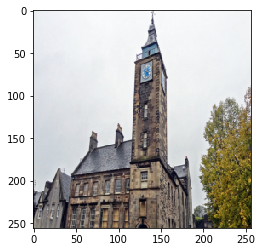

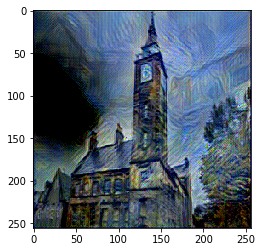

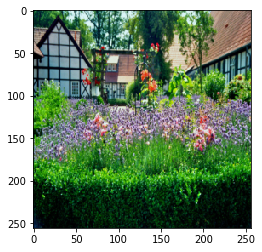

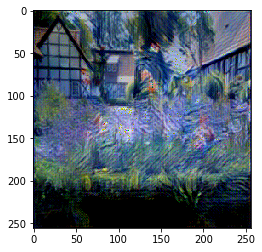

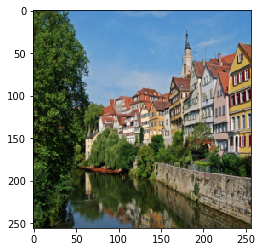

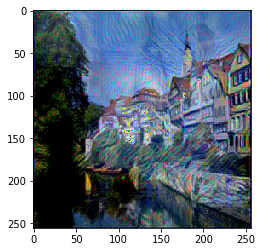

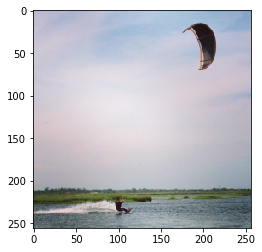

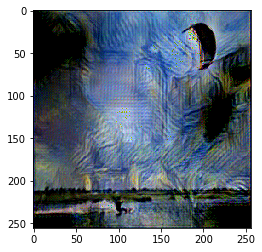

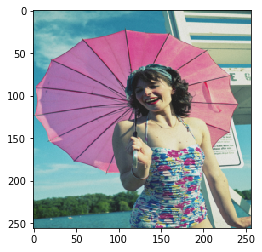

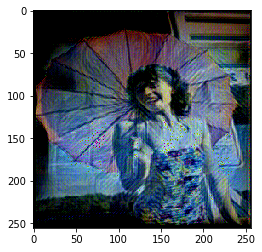

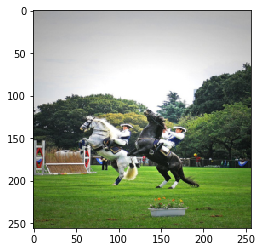

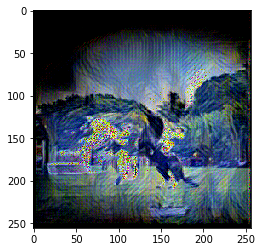

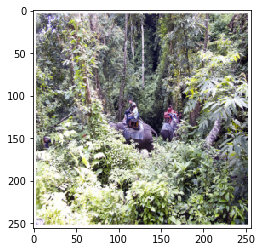

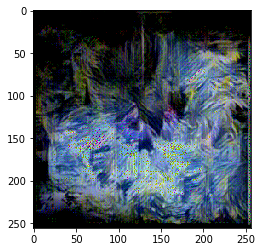

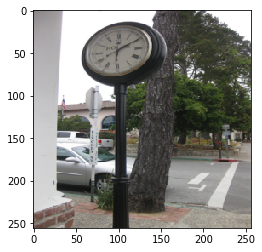

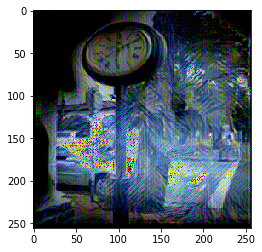

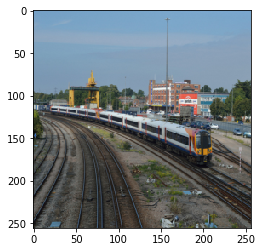

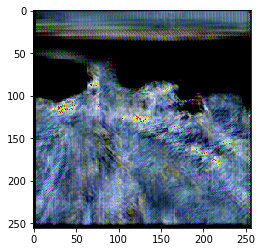

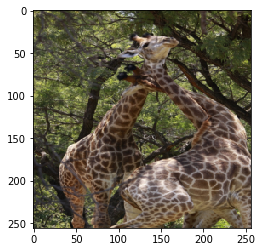

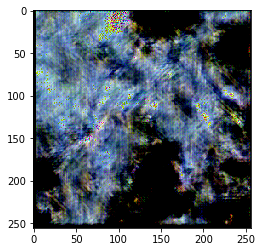

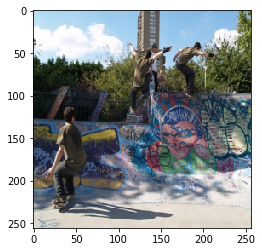

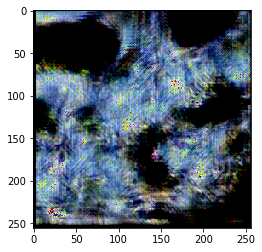

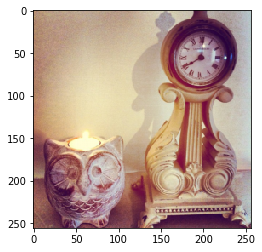

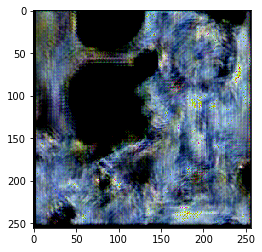

In [23]:
for i in range(12):
    show_img("final_output/input_" + str(i) + ".png")
    show_img("final_output/output_" + str(i) + ".png")